In [1]:
# Non-linear Exact Solution: Viscosity is dependent on second invariant of strain-rate

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
dim = 2
r = 1.5
n = 2
eta0 = 1.0

In [3]:
# create mesh objects
dim = 2
meshX = 64
meshY = 64

elementMesh = uw.mesh.FeMesh_Cartesian( elementType="Q2/dQ1", 
                                         elementRes=(meshX,meshY), 
                                           minCoord=(0.,0.), maxCoord=(1.,1.)  )

Q1dP0Mesh = uw.mesh.FeMesh_Cartesian( elementType="Q1/dQ0",
                                      elementRes=(2*meshX,2*meshY), 
                                      minCoord=(0.,0.), maxCoord=(1.,1.)  )

Q1Mesh =  Q1dP0Mesh # returns outer mesh by default
dP0Mesh = Q1dP0Mesh.subMesh

#elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("linear","constant"), 
#                                         elementRes=(64,64), 
#                                           minCoord=(0.,0.), 
#                                           maxCoord=(1.,1.)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [4]:
# create meshvariables
velocityField    = uw.mesh.MeshVariable( mesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=constantMesh, nodeDofCount=1 )

In [5]:
solExact = fn.analytic.SolNL(1.0,n,r)
vel=solExact.velocityFn

In [6]:
# Initialise data.. Note that we are also setting boundary conditions here
for index, coord in enumerate(linearMesh.data):
    velocityField.data[index] = 1.*vel.evaluate([ coord[0],coord[1] ])
pressureField.data[:] = 0.

In [7]:
velocityField.evaluate([0.5,0.4])

array([[ 8.38076277,  0.96909907]])

In [8]:
coord[0]

1.0

In [9]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
linearMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [10]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

In [11]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
BC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(IWalls+JWalls,IWalls+JWalls) )


In [12]:
# lets ensure temp boundaries are still what we want as the IC above might have set slightly different values
# on the boundaries
for index in IWalls+JWalls:
    velocityField.data[index]=[vel.evaluate(linearMesh.data)[index][0], vel.evaluate(linearMesh.data)[index][1]]
#for index in linearMesh.specialSets["MaxJ_VertexSet"]:
#    velocityField.data[index]=[vel.evaluate(linearMesh.data)[index][0], vel.evaluate(linearMesh.data)[index][1]]

In [13]:
velocityField.evaluate(linearMesh.data)-vel.evaluate(linearMesh.data)

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ..., 
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [14]:
velocityField.evaluate(linearMesh.data)[65]

array([-10.44046964,   0.        ])

In [15]:
vel.evaluate(linearMesh.data)[65]

array([-10.44046964,   0.        ])

In [16]:
linearMesh.specialSets["MinI_VertexSet"]

FeMesh_IndexSet([    0,   129,   258,   387,   516,   645,   774,   903,  1032,
        1161,  1290,  1419,  1548,  1677,  1806,  1935,  2064,  2193,
        2322,  2451,  2580,  2709,  2838,  2967,  3096,  3225,  3354,
        3483,  3612,  3741,  3870,  3999,  4128,  4257,  4386,  4515,
        4644,  4773,  4902,  5031,  5160,  5289,  5418,  5547,  5676,
        5805,  5934,  6063,  6192,  6321,  6450,  6579,  6708,  6837,
        6966,  7095,  7224,  7353,  7482,  7611,  7740,  7869,  7998,
        8127,  8256,  8385,  8514,  8643,  8772,  8901,  9030,  9159,
        9288,  9417,  9546,  9675,  9804,  9933, 10062, 10191, 10320,
       10449, 10578, 10707, 10836, 10965, 11094, 11223, 11352, 11481,
       11610, 11739, 11868, 11997, 12126, 12255, 12384, 12513, 12642,
       12771, 12900, 13029, 13158, 13287, 13416, 13545, 13674, 13803,
       13932, 14061, 14190, 14319, 14448, 14577, 14706, 14835, 14964,
       15093, 15222, 15351, 15480, 15609, 15738, 15867, 15996, 16125,
       162

In [17]:
# Rheology
inv2 = fn.tensor.second_invariant( 
                fn.tensor.deviatoric(
                    fn.tensor.symmetric ( 
                        velocityField.fn_gradient )) )

alpha= 1/r -1
fn_viscosity = 2* eta0 * fn.math.pow(inv2, 2.*alpha)

buoyancyFn = solExact.fn_bodyforce

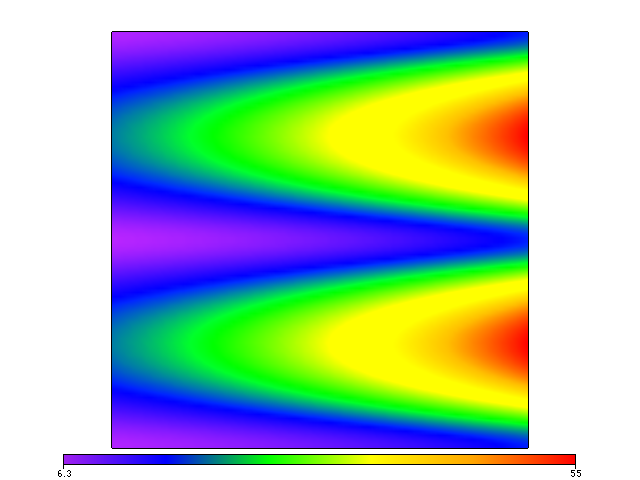

In [18]:
# lets take a look at the eta function
figEta = plt.Figure()
#figEta.Surface(buoyancyFn[1], linearMesh)
figEta.Surface(inv2, linearMesh)

figEta.show()

In [19]:

# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokes = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[BC,],
                              fn_viscosity=fn.exception.SafeMaths(fn_viscosity), 
                              fn_bodyforce=buoyancyFn )

solver=uw.systems.Solver(stokes)

solver.options.main.Q22_pc_type='uw'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 0.0
solver.options.A11.ksp_rtol=1e-7
solver.options.scr.ksp_rtol=1e-6
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.mg.levels = 5
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1
solver.options.A11.ksp_monitor=''
solver.options.scr.ksp_monitor=''
solver.options.scr.ksp_max_it=150
solver.options.main.remove_constant_pressure_null_space=True
stokes.solve = solver.solve


#  and we can check what we put in / the defaults:

print "## Solver Config"
print solver.options.main.list()
print "### A11 Config"
print solver.options.A11.list()

## Solver Config
('remove_constant_pressure_null_space', True)
('ksp_k2_type', 'GMG')
('change_backsolve', False)
('penalty', 0.0)
('pc_type', 'none')
('force_correction', True)
('k_scale_only', True)
('Q22_pc_type', 'uw')
('change_A11rhspresolve', False)
('ksp_type', 'bsscr')
('rescale_equations', False)
('restore_K', True)
None
### A11 Config
('ksp_monitor', '')
('ksp_type', 'fgmres')
('ksp_rtol', 1e-07)
None


In [20]:
step=0
while step < 1:
    stokes.solve(nonLinearIterate=True)
    step=step+1

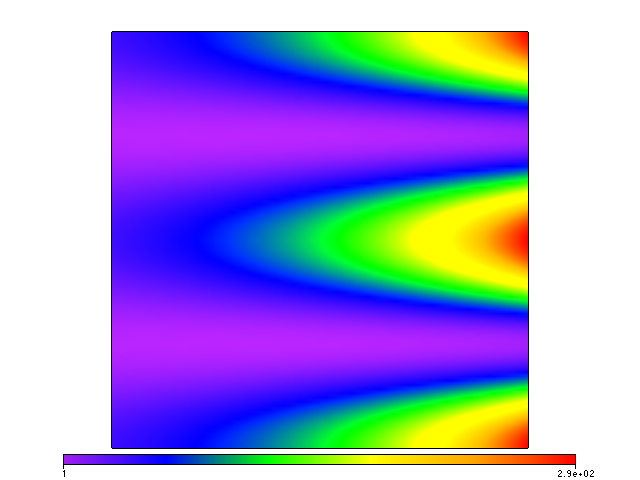

In [21]:
# lets check FEM solution
velMag = plt.Figure()
velMag.Surface(fn.math.dot(velocityField,velocityField), linearMesh)
velMag.show()

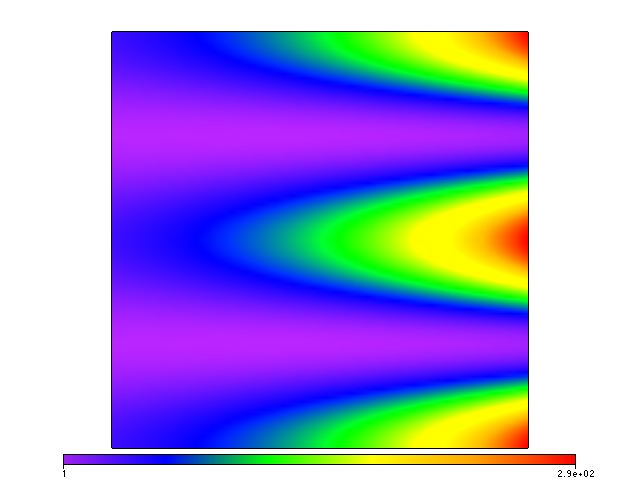

In [22]:
# and analytic
solA=solExact
velMagA = plt.Figure()
velMagA.Surface(fn.math.dot(solA.velocityFn,solA.velocityFn), linearMesh)
velMagA.show()

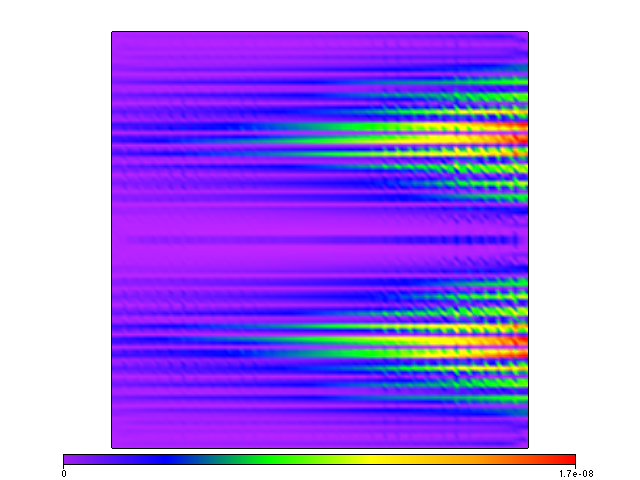

In [23]:
# and difference
velDiff = plt.Figure()
velDiff.Surface(fn.math.dot(solA.velocityFn - velocityField,solA.velocityFn - velocityField), linearMesh)
velDiff.show()

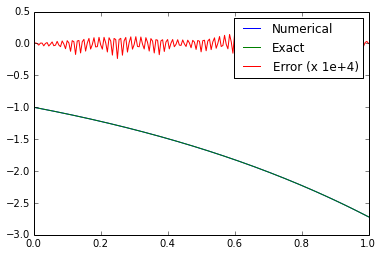

In [24]:
import numpy as np
N=201
a=np.ndarray(shape=(N,2))
a[:,1]=0.75*np.ones(N)
a[:,0]=np.linspace(0,1,N)
import matplotlib.pyplot as mplt
import matplotlib.pylab as pylab
vy=solA.velocityFn[1].evaluate(a)[:,0]
ax=a[:,0]
vf=velocityField[1].evaluate(a)[:,0]
mplt.plot(ax,vf,label='Numerical')
mplt.plot(ax,vy,label='Exact')
mplt.plot(ax,10000*(vy-vf),label='Error (x 1e+4)')
mplt.legend()


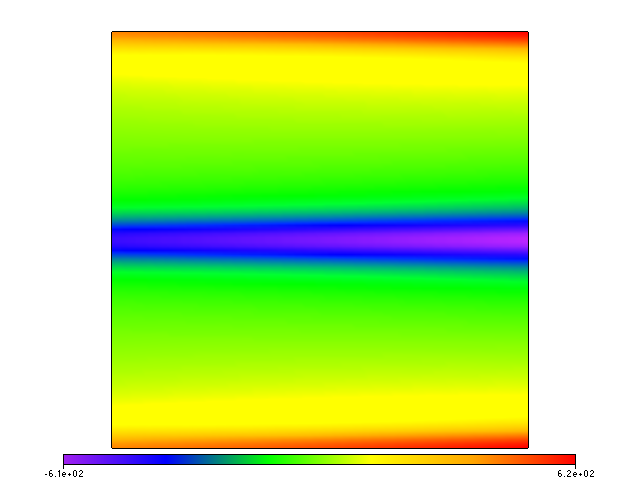

In [25]:
# lets check FEM solution
p = plt.Figure()
p.Surface(pressureField, linearMesh)
p.show()

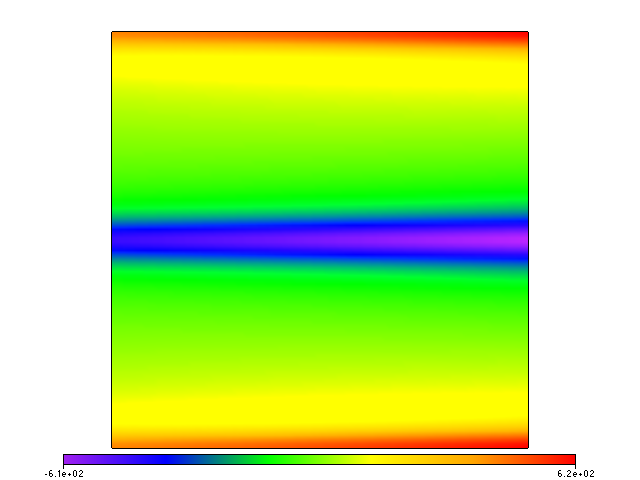

In [26]:
# and analytic
solA=solExact
pA = plt.Figure()
pA.Surface(solA.pressureFn, linearMesh)
pA.show()

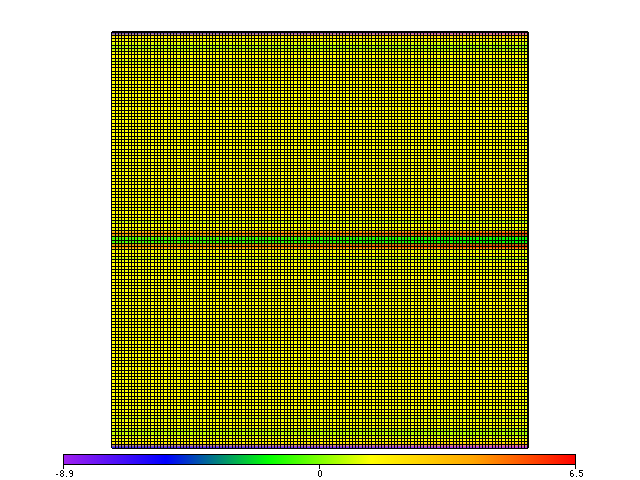

In [27]:
pDiff = plt.Figure()
pDiff.Surface(solA.pressureFn-pressureField, Q1Mesh)
pDiff.Mesh(Q1Mesh)
pDiff.show()

In [28]:
integ = uw.utils.Integral(pressureField,
                            linearMesh,
                            integrationType="volume")


In [29]:
integ.integrate()

[2.3923571457196147e-13]

In [30]:
integ = uw.utils.Integral(solA.pressureFn,
                            linearMesh,
                            integrationType="volume")

In [31]:
integ.integrate()

[-9.868668382484458e-14]

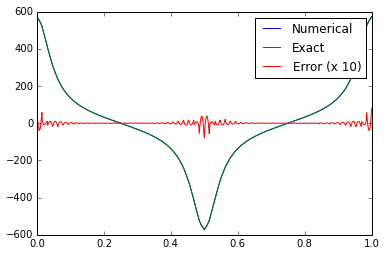

In [32]:
N=801
a=np.ndarray(shape=(N,2))
a[:,0]=0.75*np.ones(N)
a[:,1]=np.linspace(0,1,N)
ax=a[:,1]
pex=solA.pressureFn.evaluate(a)[:,0]
y=a[:,1]
pfd=pressureField.evaluate(a)[:,0]
mplt.plot(y,pfd,label='Numerical')
mplt.plot(y,pex,label='Exact')
mplt.plot(y,10*(pfd-pex),label='Error (x 10)')
#mplt.xlim(0.492,0.496)
#mplt.ylim(-600,-500)
mplt.legend()


In [33]:
a=np.ndarray(shape=(constantMesh.data.shape[0],1))
b=np.ndarray(shape=(constantMesh.data.shape[0],1))
for index, coord in enumerate(constantMesh.data):
    a[index] = pressureField.evaluate([ coord[0],coord[1] ])
    b[index] = solA.pressureFn.evaluate([ coord[0],coord[1] ])

In [34]:
a[:,0][0:3]

array([ 437.77785716,  439.01356743,  419.25786342])

In [35]:
b[:,0][0:3]

array([ 438.71840275,  439.86238751,  419.87705747])

In [36]:
c=a-b

In [37]:
n=16
numNodes=3
off=meshX*n*numNodes
c[:,0][0+off:30+off]

array([-0.03182371,  0.04469726, -0.03245765,  0.04241048, -0.03163171,
        0.04447782, -0.03214071,  0.04224856, -0.03127525,  0.04407283,
       -0.03167388,  0.04194331, -0.03074512,  0.04350794, -0.03105192,
        0.04147981, -0.03005631,  0.04279754, -0.03028492,  0.04086639,
       -0.02922064,  0.04194959, -0.02938131,  0.0401115 , -0.0282489 ,
        0.0409651 , -0.0283415 ,  0.03922317, -0.02714198,  0.03985139])

In [38]:
b[:,0]

array([ 438.71840275,  439.86238751,  419.87705747, ...,  582.94156403,
        610.68844695,  609.10018141])

In [39]:
constantMesh.data[:][40:50]

array([[ 0.16015625,  0.00390625],
       [ 0.16796875,  0.00390625],
       [ 0.16796875,  0.01171875],
       [ 0.16015625,  0.01171875],
       [ 0.17578125,  0.00390625],
       [ 0.18359375,  0.00390625],
       [ 0.18359375,  0.01171875],
       [ 0.17578125,  0.01171875],
       [ 0.19140625,  0.00390625],
       [ 0.19921875,  0.00390625]])

In [40]:
pressureField.data.size

16384

In [41]:
solver.options.mg.help()


    Set Multigrid PETSc options
    
    active = <True,False>           : activates Multigrid
    levels = <n>                    : Multigrid grid levels
    pc_mg_type  <additive,multiplicative,full,kaskade> : multiplicative is default
    pc_mg_cycle_type <v,w>          : v or w
    pc_mg_multiplicative_cycles <n> : Sets the number of cycles to use for each preconditioner 
                                      step of multigrid
    mg_levels_ksp_type <minres>     : Krylov method
    mg_levels_ksp_max_its <n>       : Maximum iterations for Krylov method
    mg_levels_ksp_convergence_test <default, skip>  :
    mg_levels_pc_type <sor>         : Preconditioner type
    pc_mg_smoothup <n>              : Number of smoothing steps after interpolation
    pc_mg_smoothdown <n>            : Number of smoothing steps before applying restriction operator
    
